## Import Libraries

In [1]:
# %pip install -r requirements.txt

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import calendar
from tqdm import tqdm
import random
import time

plt.style.use("dark_background")

## Download Data

### Define Stock Symbol and Date Range

In [3]:
symbol = "^GSPC"
start_date = "1990-01-01"
end_date = "2024-12-31"
train_cutoff_date = "2019-12-31"

### Download Historical Price Data

In [4]:
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = df.columns.get_level_values(0)
df = df[['Close']]
df.head()

C:\Users\Brian\AppData\Local\Temp\ipykernel_17700\1241090399.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close
Date,
1990-01-02,359.690002
1990-01-03,358.760010
1990-01-04,355.670013
1990-01-05,352.200012
1990-01-08,353.790009


### Plot Historical Closing Price

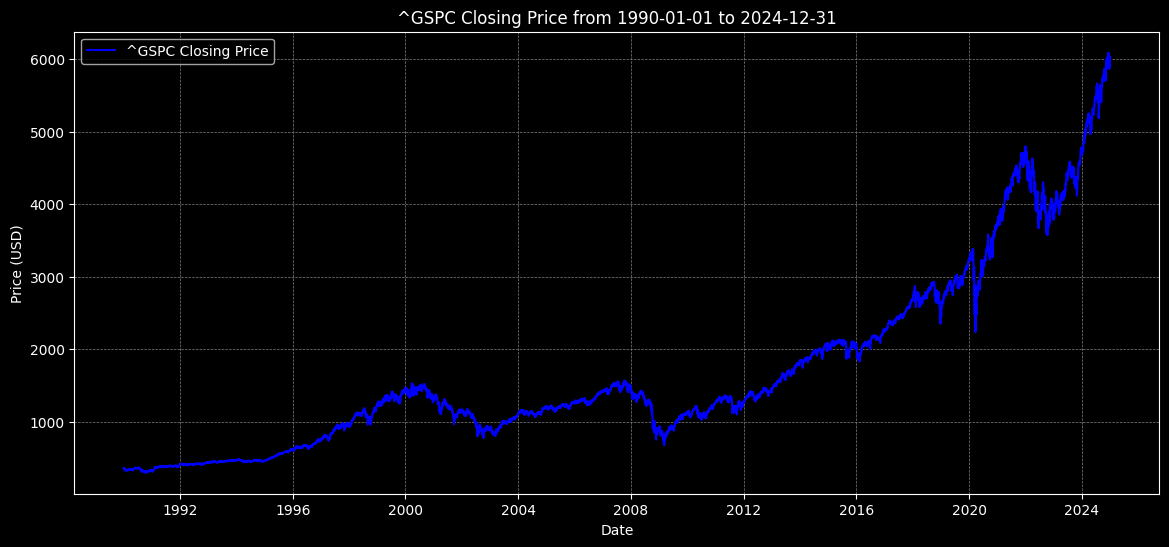

In [5]:
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label=f"{symbol} Closing Price", color='blue')
plt.title(f"{symbol} Closing Price from {start_date} to {end_date}")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

## Split Data into Training and Testing Sets

In [6]:
df_train = df.loc[start_date:train_cutoff_date].copy()
df_test = df.loc[train_cutoff_date:end_date].copy()

print("Training range:", start_date, "to", train_cutoff_date)
print("Testing range:", train_cutoff_date, "to", end_date)

Training range: 1990-01-01 to 2019-12-31
Testing range: 2019-12-31 to 2024-12-31


## Define Single Moving Average Crossover Backtesting Strategy

In [7]:
def backtest_strategy_double_ma(data, short_window, long_window, initial_capital):
    df = data.copy()

    # Compute short and long moving averages
    df['SMA_Short'] = df['Close'].rolling(window=short_window).mean()
    df['SMA_Long'] = df['Close'].rolling(window=long_window).mean()

    # Generate buy signal when short MA crosses above long MA
    df['Signal'] = 0
    df.loc[df['SMA_Short'] > df['SMA_Long'], 'Signal'] = 1

    # Lag position by 1 day
    df['Position'] = df['Signal'].shift(1)

    # Calculate daily returns
    df['Return'] = df['Close'].pct_change()
    df['Strategy Return'] = df['Position'] * df['Return']

    # Equity curve
    df['Equity Curve'] = (1 + df['Strategy Return']).cumprod() * initial_capital

    # Metrics
    final_value = df['Equity Curve'].iloc[-1]
    num_trades = df['Position'].diff().abs().sum()

    return final_value, num_trades, df

## Grid Search for Optimal Short and Long SMA Windows

In [8]:
initial_capital = 10

In [9]:
# Define full range of candidate windows (exhaustive within limit 200)
short_range = list(range(1, 200))     # Short MA window candidates: 1 to 199
long_range = list(range(2, 201))      # Long MA window candidates: 2 to 200

num_runs = 10
num_samples = 50  # Number of random samples per run (you can adjust this)
times = []

best_final_value = -float('inf')
best_short_window = None
best_long_window = None
best_num_trades = None

for run in range(num_runs):
    print(f"Random Search Run {run+1}/{num_runs}")

    results = []

    # Generate valid (short, long) pairs with short < long
    valid_pairs = [(s, l) for s in short_range for l in long_range if s < l]

    # Sample without replacement from valid pairs
    random_pairs = random.sample(valid_pairs, min(num_samples, len(valid_pairs)))

    start_time = time.time()
    for short_window, long_window in tqdm(random_pairs):
        final_value, trades, _ = backtest_strategy_double_ma(df_train, short_window, long_window, initial_capital)
        results.append({
            'Short Window': short_window,
            'Long Window': long_window,
            'Final Value': final_value,
            'Number of Trades': trades
        })
    end_time = time.time()

    times.append(end_time - start_time)

    results_df = pd.DataFrame(results)
    top_strategy = results_df.sort_values(by='Final Value', ascending=False).iloc[0]

    # Track the best overall strategy across runs
    if top_strategy['Final Value'] > best_final_value:
        best_final_value = top_strategy['Final Value']
        best_short_window = int(top_strategy['Short Window'])
        best_long_window = int(top_strategy['Long Window'])
        best_num_trades = int(top_strategy['Number of Trades'])

average_time = sum(times) / num_runs

print(f"\nAverage Random Search runtime over {num_runs} runs: {average_time:.2f} seconds ({average_time/60:.2f} minutes).")
print("\nBest Strategy Parameters Found (best of all runs):")
print(f"Short MA Window : {best_short_window}")
print(f"Long MA Window  : {best_long_window}")
print(f"Final Value     : ${best_final_value:,.2f}")
print(f"Number of Trades: {best_num_trades}")

Random Search Run 1/10


100%|██████████| 50/50 [00:00<00:00, 139.31it/s]


Random Search Run 2/10


100%|██████████| 50/50 [00:00<00:00, 151.07it/s]


Random Search Run 3/10


100%|██████████| 50/50 [00:00<00:00, 126.98it/s]


Random Search Run 4/10


100%|██████████| 50/50 [00:00<00:00, 173.01it/s]


Random Search Run 5/10


100%|██████████| 50/50 [00:00<00:00, 146.93it/s]


Random Search Run 6/10


100%|██████████| 50/50 [00:00<00:00, 169.36it/s]


Random Search Run 7/10


100%|██████████| 50/50 [00:00<00:00, 185.92it/s]


Random Search Run 8/10


100%|██████████| 50/50 [00:00<00:00, 182.08it/s]


Random Search Run 9/10


100%|██████████| 50/50 [00:00<00:00, 188.14it/s]


Random Search Run 10/10


100%|██████████| 50/50 [00:00<00:00, 154.01it/s]


Average Random Search runtime over 10 runs: 0.32 seconds (0.01 minutes).

Best Strategy Parameters Found (best of all runs):
Short MA Window : 141
Long MA Window  : 164
Final Value     : $121.25
Number of Trades: 55


## Visualize Moving Averages on Training Data

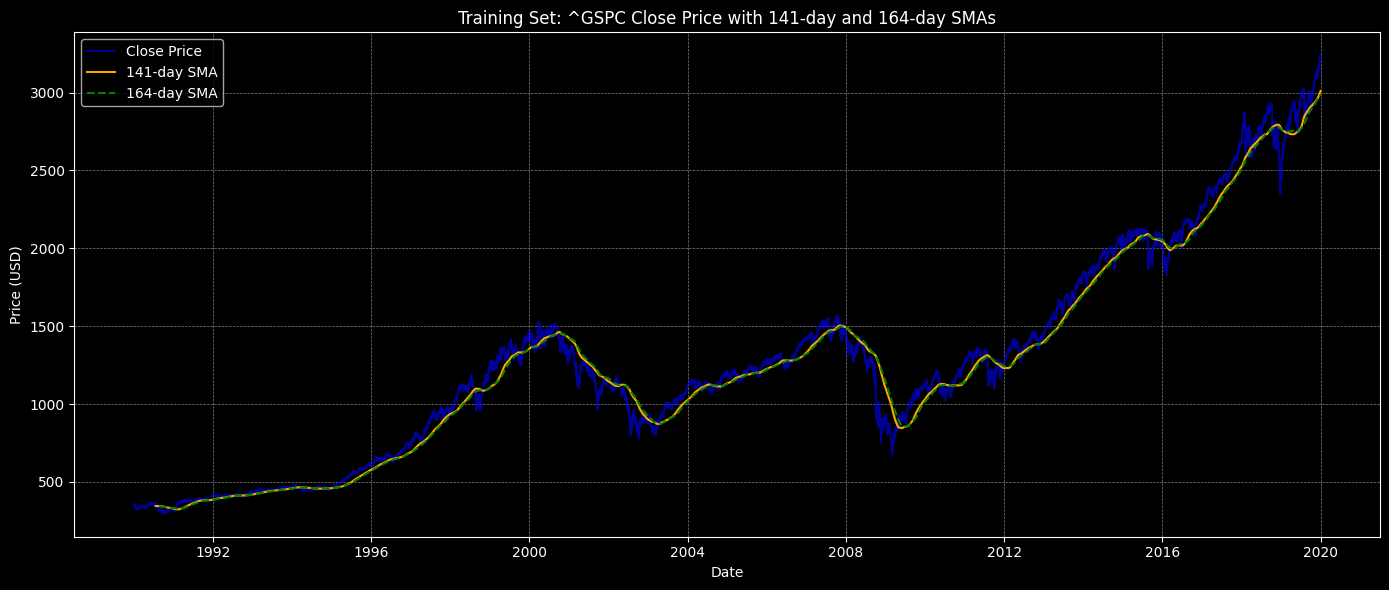

In [10]:
# Run backtest on training data with best short and long MA windows
_, _, df_train_result = backtest_strategy_double_ma(df_train, best_short_window, best_long_window, initial_capital)

# Plot Close price and the two moving averages (full dataset)
plt.figure(figsize=(14, 6))
plt.plot(df_train_result['Close'], label='Close Price', alpha=0.6, color='blue')
plt.plot(df_train_result['SMA_Short'], label=f'{best_short_window}-day SMA', color='orange', linestyle='-')
plt.plot(df_train_result['SMA_Long'], label=f'{best_long_window}-day SMA', color='green', linestyle='--')

# Chart formatting
plt.title(f"Training Set: {symbol} Close Price with {best_short_window}-day and {best_long_window}-day SMAs")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Visualize Buy/Sell Signals on Test Data

In [11]:
final_value, trades, df_test_result = backtest_strategy_double_ma(
    df_test,
    best_short_window,
    best_long_window,
    initial_capital
)

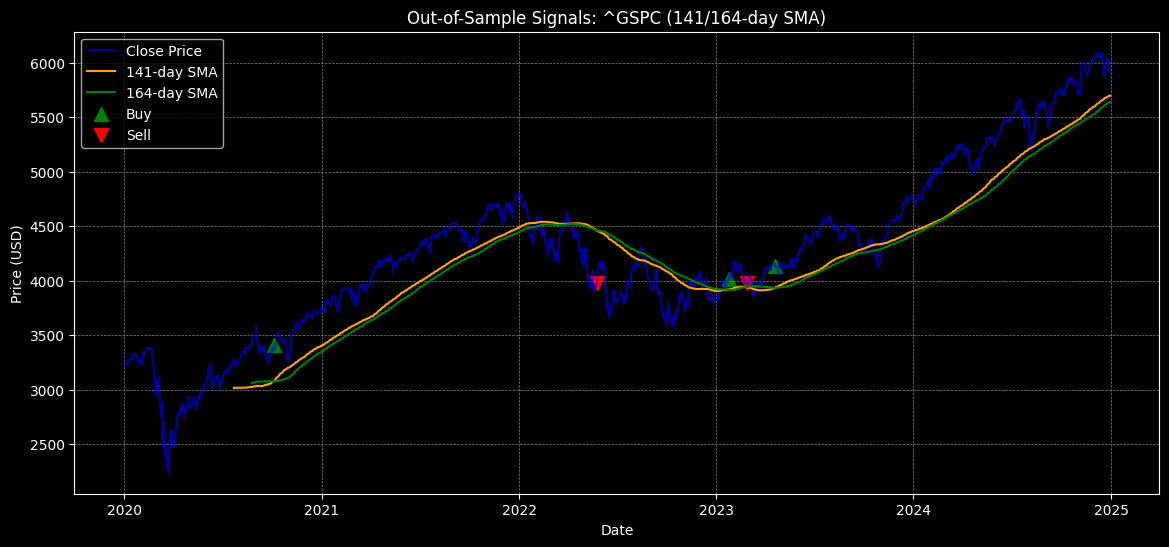

In [12]:
plt.figure(figsize=(14, 6))
plt.plot(df_test_result['Close'], label='Close Price', alpha=0.6, color='blue')
plt.plot(df_test_result['SMA_Short'], label=f'{best_short_window}-day SMA', color='orange')
plt.plot(df_test_result['SMA_Long'], label=f'{best_long_window}-day SMA', color='green')

# Identify buy signals: when short MA crosses above long MA
buy_signals = df_test_result[(df_test_result['SMA_Short'].shift(1) <= df_test_result['SMA_Long'].shift(1)) &
                             (df_test_result['SMA_Short'] > df_test_result['SMA_Long'])]

# Identify sell signals: when short MA crosses below long MA
sell_signals = df_test_result[(df_test_result['SMA_Short'].shift(1) >= df_test_result['SMA_Long'].shift(1)) &
                              (df_test_result['SMA_Short'] < df_test_result['SMA_Long'])]

plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', s=100, label='Buy')
plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', s=100, label='Sell')

plt.title(f"Out-of-Sample Signals: {symbol} ({best_short_window}/{best_long_window}-day SMA)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

## Compare Strategy vs Buy & Hold Perfomance

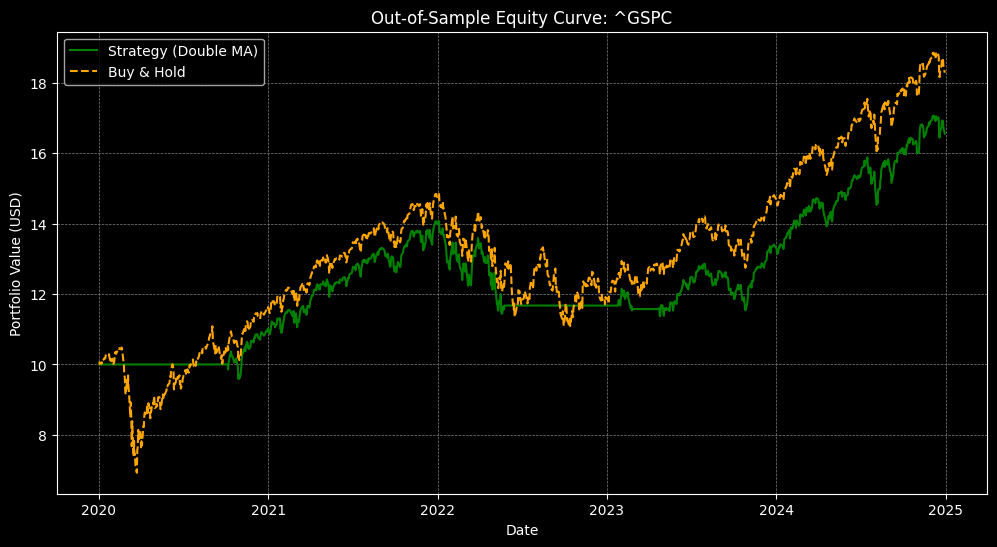

In [13]:
# Calculate Buy & Hold cumulative portfolio value
df_test_result['Buy & Hold'] = (1 + df_test_result['Return']).cumprod() * initial_capital

# Plot strategy equity curve vs buy & hold
plt.figure(figsize=(12, 6))
plt.plot(df_test_result['Equity Curve'], label='Strategy (Double MA)', color='green')
plt.plot(df_test_result['Buy & Hold'], label='Buy & Hold', linestyle='--', color='orange')

plt.title(f"Out-of-Sample Equity Curve: {symbol}")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (USD)")
plt.legend()
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

## Final Perfomance Summary

In [14]:
final_strategy_value = df_test_result['Equity Curve'].iloc[-1]
final_bh_value = df_test_result['Buy & Hold'].iloc[-1]

strategy_return_pct = ((final_strategy_value / initial_capital) - 1) * 100
bh_return_pct = ((final_bh_value / initial_capital) - 1) * 100

summary = pd.DataFrame({
    "Metric": [
        "Optimized Short MA Window", 
        "Optimized Long MA Window", 
        "Final Strategy Value (Test)", 
        "Final Buy & Hold Value (Test)", 
        "Strategy Return (%)", 
        "Buy & Hold Return (%)", 
        "Number of Trades (Test)",
        "Average Time per Run (seconds)"
    ],
    "Value": [
        best_short_window, 
        best_long_window, 
        final_strategy_value, 
        final_bh_value, 
        strategy_return_pct, 
        bh_return_pct, 
        int(trades),
        average_time
    ]
}).set_index("Metric")

# Save summary to CSV
summary.to_csv("strategy_summary.csv")

summary

,Value
Metric,
Optimized Short MA Window,141.000000
Optimized Long MA Window,164.000000
Final Strategy Value (Test),16.551372
Final Buy & Hold Value (Test),18.283324
Strategy Return (%),65.513722
Buy & Hold Return (%),82.833244
Number of Trades (Test),5.000000
Average Time per Run (seconds),0.319625


## Monthly Return (Test Period)

C:\Users\Brian\AppData\Local\Temp\ipykernel_17700\503390228.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  strategy_returns = df_test_result['Strategy Return'].resample('M').apply(lambda x: (1 + x).prod() - 1)
C:\Users\Brian\AppData\Local\Temp\ipykernel_17700\503390228.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  buyhold_returns = df_test_result['Return'].resample('M').apply(lambda x: (1 + x).prod() - 1)


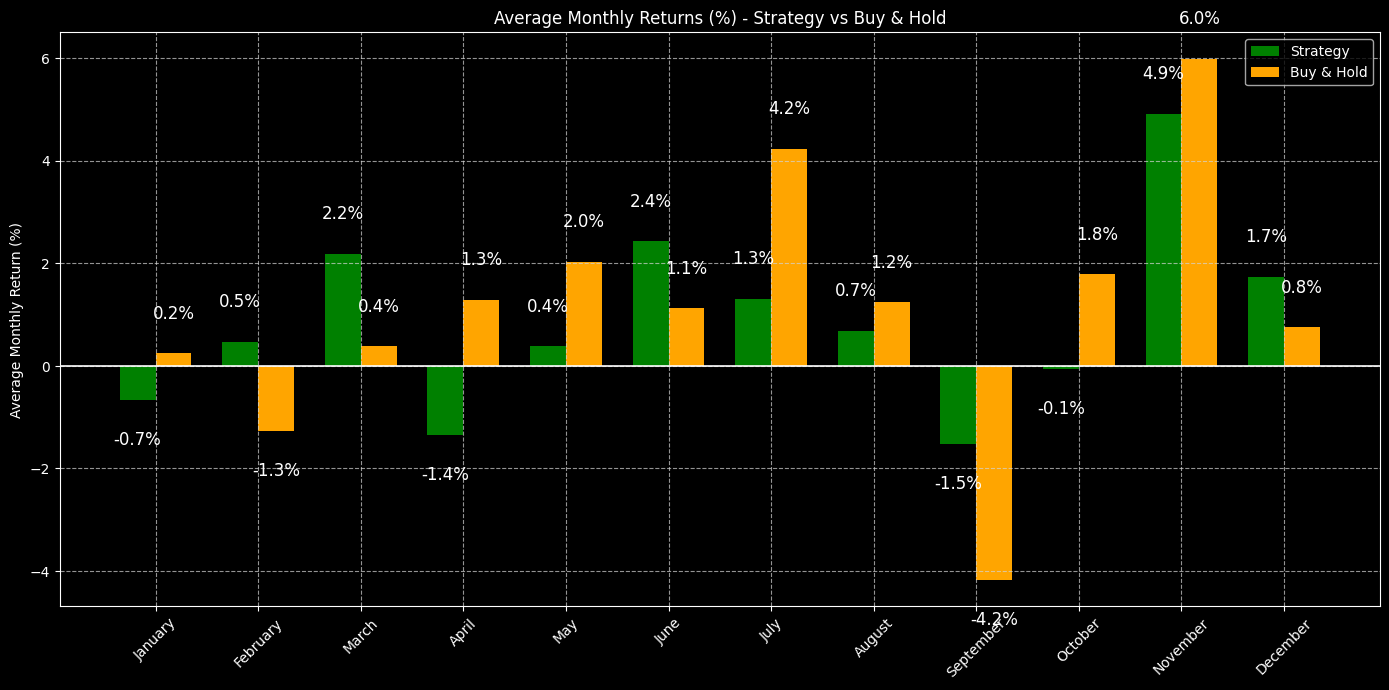

In [15]:
# Calculate monthly returns for strategy and buy & hold
strategy_returns = df_test_result['Strategy Return'].resample('M').apply(lambda x: (1 + x).prod() - 1)
buyhold_returns = df_test_result['Return'].resample('M').apply(lambda x: (1 + x).prod() - 1)

# Convert to DataFrame with Year and Month for strategy
strategy_df = strategy_returns.to_frame(name='Strategy Return')
strategy_df['Year'] = strategy_df.index.year
strategy_df['Month'] = strategy_df.index.month_name()

# Convert to DataFrame with Year and Month for buy & hold
buyhold_df = buyhold_returns.to_frame(name='Buy & Hold Return')
buyhold_df['Year'] = buyhold_df.index.year
buyhold_df['Month'] = buyhold_df.index.month_name()

# Compute average monthly returns across years
avg_strategy = strategy_df.groupby('Month')['Strategy Return'].mean()
avg_buyhold = buyhold_df.groupby('Month')['Buy & Hold Return'].mean()

# Order months Jan to Dec
month_order = list(calendar.month_name)[1:]
avg_strategy = avg_strategy.reindex(month_order) * 100  # convert to percentage
avg_buyhold = avg_buyhold.reindex(month_order) * 100    # convert to percentage

# Bar positions and width
x = np.arange(len(month_order))
width = 0.35

plt.figure(figsize=(14, 7))

# Plot bars for strategy and buy & hold returns
bars1 = plt.bar(x - width/2, avg_strategy, width, label='Strategy', color='green')
bars2 = plt.bar(x + width/2, avg_buyhold, width, label='Buy & Hold', color='orange')

# Horizontal zero line at y=0
plt.axhline(0, color='white', linewidth=1.2)

# Add both horizontal and vertical grid lines with light gray dashed style and opacity
plt.grid(axis='y', color='lightgray', linestyle='--', alpha=0.7)
plt.grid(axis='x', color='lightgray', linestyle='--', alpha=0.7)

# Annotate each bar with its value
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height >= 0:
            plt.text(bar.get_x() + bar.get_width() / 2, height + 0.6, f"{height:.1f}%", 
                     ha='center', va='bottom', fontsize=12)
        else:
            plt.text(bar.get_x() + bar.get_width() / 2, height - 0.6, f"{height:.1f}%", 
                     ha='center', va='top', fontsize=12)

# Set x-axis labels and rotation for readability
plt.xticks(x, month_order, rotation=45)

plt.ylabel('Average Monthly Return (%)')
plt.title('Average Monthly Returns (%) - Strategy vs Buy & Hold')
plt.legend()
plt.tight_layout()
plt.show()